# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./UCIHAR/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./UCIHAR/", split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"

/home/gabriele/Documents/TestingArea/DeepLearningHAR/utils/utilities.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X[:,:,i_ch] = dat_.as_matrix()


In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
batch_size = 500       # Batch size, prima 600
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [9]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [10]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.797191 Train acc: 0.190000
Epoch: 0/1000 Iteration: 10 Train loss: 1.752981 Train acc: 0.190000
Epoch: 0/1000 Iteration: 10 Validation loss: 1.726277 Validation acc: 0.294667
Epoch: 1/1000 Iteration: 15 Train loss: 1.725992 Train acc: 0.220000
Epoch: 1/1000 Iteration: 20 Train loss: 1.675933 Train acc: 0.216000
Epoch: 1/1000 Iteration: 20 Validation loss: 1.646929 Validation acc: 0.340000
Epoch: 2/1000 Iteration: 25 Train loss: 1.648108 Train acc: 0.230000
Epoch: 2/1000 Iteration: 30 Train loss: 1.629454 Train acc: 0.252000
Epoch: 2/1000 Iteration: 30 Validation loss: 1.584970 Validation acc: 0.356000
Epoch: 3/1000 Iteration: 35 Train loss: 1.583550 Train acc: 0.304000
Epoch: 3/1000 Iteration: 40 Train loss: 1.578935 Train acc: 0.284000
Epoch: 3/1000 Iteration: 40 Validation loss: 1.528511 Validation acc: 0.378667
Epoch: 4/1000 Iteration: 45 Train loss: 1.534875 Train acc: 0.304000
Epoch: 4/1000 Iteration: 50 Train loss: 1.491299 Train acc: 0.35

Epoch: 34/1000 Iteration: 380 Train loss: 0.211714 Train acc: 0.928000
Epoch: 34/1000 Iteration: 380 Validation loss: 0.184859 Validation acc: 0.926667
Epoch: 34/1000 Iteration: 385 Train loss: 0.202486 Train acc: 0.940000
Epoch: 35/1000 Iteration: 390 Train loss: 0.229495 Train acc: 0.912000
Epoch: 35/1000 Iteration: 390 Validation loss: 0.178781 Validation acc: 0.929333
Epoch: 35/1000 Iteration: 395 Train loss: 0.208977 Train acc: 0.934000
Epoch: 36/1000 Iteration: 400 Train loss: 0.221250 Train acc: 0.910000
Epoch: 36/1000 Iteration: 400 Validation loss: 0.173768 Validation acc: 0.931333
Epoch: 36/1000 Iteration: 405 Train loss: 0.219392 Train acc: 0.916000
Epoch: 37/1000 Iteration: 410 Train loss: 0.202666 Train acc: 0.940000
Epoch: 37/1000 Iteration: 410 Validation loss: 0.168960 Validation acc: 0.932000
Epoch: 37/1000 Iteration: 415 Train loss: 0.202344 Train acc: 0.912000
Epoch: 38/1000 Iteration: 420 Train loss: 0.188660 Train acc: 0.934000
Epoch: 38/1000 Iteration: 420 Validat

Epoch: 68/1000 Iteration: 750 Train loss: 0.111198 Train acc: 0.958000
Epoch: 68/1000 Iteration: 750 Validation loss: 0.115801 Validation acc: 0.951333
Epoch: 68/1000 Iteration: 755 Train loss: 0.108786 Train acc: 0.968000
Epoch: 69/1000 Iteration: 760 Train loss: 0.113271 Train acc: 0.958000
Epoch: 69/1000 Iteration: 760 Validation loss: 0.115026 Validation acc: 0.953333
Epoch: 69/1000 Iteration: 765 Train loss: 0.128120 Train acc: 0.958000
Epoch: 69/1000 Iteration: 770 Train loss: 0.117151 Train acc: 0.952000
Epoch: 69/1000 Iteration: 770 Validation loss: 0.114980 Validation acc: 0.950667
Epoch: 70/1000 Iteration: 775 Train loss: 0.156553 Train acc: 0.930000
Epoch: 70/1000 Iteration: 780 Train loss: 0.112158 Train acc: 0.962000
Epoch: 70/1000 Iteration: 780 Validation loss: 0.114088 Validation acc: 0.952000
Epoch: 71/1000 Iteration: 785 Train loss: 0.141807 Train acc: 0.942000
Epoch: 71/1000 Iteration: 790 Train loss: 0.120380 Train acc: 0.952000
Epoch: 71/1000 Iteration: 790 Validat

Epoch: 101/1000 Iteration: 1115 Train loss: 0.122344 Train acc: 0.950000
Epoch: 101/1000 Iteration: 1120 Train loss: 0.100216 Train acc: 0.960000
Epoch: 101/1000 Iteration: 1120 Validation loss: 0.105032 Validation acc: 0.954000
Epoch: 102/1000 Iteration: 1125 Train loss: 0.120314 Train acc: 0.952000
Epoch: 102/1000 Iteration: 1130 Train loss: 0.115999 Train acc: 0.956000
Epoch: 102/1000 Iteration: 1130 Validation loss: 0.104974 Validation acc: 0.956000
Epoch: 103/1000 Iteration: 1135 Train loss: 0.101898 Train acc: 0.956000
Epoch: 103/1000 Iteration: 1140 Train loss: 0.095499 Train acc: 0.958000
Epoch: 103/1000 Iteration: 1140 Validation loss: 0.104870 Validation acc: 0.954667
Epoch: 104/1000 Iteration: 1145 Train loss: 0.100414 Train acc: 0.960000
Epoch: 104/1000 Iteration: 1150 Train loss: 0.115920 Train acc: 0.948000
Epoch: 104/1000 Iteration: 1150 Validation loss: 0.104562 Validation acc: 0.954000
Epoch: 104/1000 Iteration: 1155 Train loss: 0.104921 Train acc: 0.960000
Epoch: 105/

Epoch: 134/1000 Iteration: 1475 Train loss: 0.085994 Train acc: 0.964000
Epoch: 134/1000 Iteration: 1480 Train loss: 0.111427 Train acc: 0.958000
Epoch: 134/1000 Iteration: 1480 Validation loss: 0.099759 Validation acc: 0.957333
Epoch: 134/1000 Iteration: 1485 Train loss: 0.102516 Train acc: 0.968000
Epoch: 135/1000 Iteration: 1490 Train loss: 0.127165 Train acc: 0.940000
Epoch: 135/1000 Iteration: 1490 Validation loss: 0.099691 Validation acc: 0.957333
Epoch: 135/1000 Iteration: 1495 Train loss: 0.099083 Train acc: 0.964000
Epoch: 136/1000 Iteration: 1500 Train loss: 0.126512 Train acc: 0.944000
Epoch: 136/1000 Iteration: 1500 Validation loss: 0.099516 Validation acc: 0.957333
Epoch: 136/1000 Iteration: 1505 Train loss: 0.091950 Train acc: 0.958000
Epoch: 137/1000 Iteration: 1510 Train loss: 0.110839 Train acc: 0.952000
Epoch: 137/1000 Iteration: 1510 Validation loss: 0.099348 Validation acc: 0.957333
Epoch: 137/1000 Iteration: 1515 Train loss: 0.103448 Train acc: 0.956000
Epoch: 138/

Epoch: 166/1000 Iteration: 1835 Train loss: 0.092961 Train acc: 0.956000
Epoch: 167/1000 Iteration: 1840 Train loss: 0.101512 Train acc: 0.960000
Epoch: 167/1000 Iteration: 1840 Validation loss: 0.095103 Validation acc: 0.958000
Epoch: 167/1000 Iteration: 1845 Train loss: 0.091926 Train acc: 0.966000
Epoch: 168/1000 Iteration: 1850 Train loss: 0.080138 Train acc: 0.968000
Epoch: 168/1000 Iteration: 1850 Validation loss: 0.094932 Validation acc: 0.958000
Epoch: 168/1000 Iteration: 1855 Train loss: 0.082784 Train acc: 0.964000
Epoch: 169/1000 Iteration: 1860 Train loss: 0.086228 Train acc: 0.964000
Epoch: 169/1000 Iteration: 1860 Validation loss: 0.094834 Validation acc: 0.958667
Epoch: 169/1000 Iteration: 1865 Train loss: 0.099241 Train acc: 0.960000
Epoch: 169/1000 Iteration: 1870 Train loss: 0.082269 Train acc: 0.972000
Epoch: 169/1000 Iteration: 1870 Validation loss: 0.094669 Validation acc: 0.958667
Epoch: 170/1000 Iteration: 1875 Train loss: 0.122600 Train acc: 0.944000
Epoch: 170/

Epoch: 199/1000 Iteration: 2195 Train loss: 0.091165 Train acc: 0.960000
Epoch: 199/1000 Iteration: 2200 Train loss: 0.076481 Train acc: 0.974000
Epoch: 199/1000 Iteration: 2200 Validation loss: 0.090090 Validation acc: 0.960667
Epoch: 200/1000 Iteration: 2205 Train loss: 0.116525 Train acc: 0.944000
Epoch: 200/1000 Iteration: 2210 Train loss: 0.086631 Train acc: 0.964000
Epoch: 200/1000 Iteration: 2210 Validation loss: 0.089963 Validation acc: 0.960667
Epoch: 201/1000 Iteration: 2215 Train loss: 0.102881 Train acc: 0.948000
Epoch: 201/1000 Iteration: 2220 Train loss: 0.082055 Train acc: 0.968000
Epoch: 201/1000 Iteration: 2220 Validation loss: 0.089909 Validation acc: 0.959333
Epoch: 202/1000 Iteration: 2225 Train loss: 0.098407 Train acc: 0.954000
Epoch: 202/1000 Iteration: 2230 Train loss: 0.085861 Train acc: 0.970000
Epoch: 202/1000 Iteration: 2230 Validation loss: 0.090003 Validation acc: 0.958667
Epoch: 203/1000 Iteration: 2235 Train loss: 0.080304 Train acc: 0.966000
Epoch: 203/

Epoch: 232/1000 Iteration: 2555 Train loss: 0.089470 Train acc: 0.962000
Epoch: 232/1000 Iteration: 2560 Train loss: 0.081914 Train acc: 0.968000
Epoch: 232/1000 Iteration: 2560 Validation loss: 0.084635 Validation acc: 0.958000
Epoch: 233/1000 Iteration: 2565 Train loss: 0.075437 Train acc: 0.968000
Epoch: 233/1000 Iteration: 2570 Train loss: 0.067323 Train acc: 0.966000
Epoch: 233/1000 Iteration: 2570 Validation loss: 0.084560 Validation acc: 0.958667
Epoch: 234/1000 Iteration: 2575 Train loss: 0.074519 Train acc: 0.968000
Epoch: 234/1000 Iteration: 2580 Train loss: 0.088799 Train acc: 0.956000
Epoch: 234/1000 Iteration: 2580 Validation loss: 0.084528 Validation acc: 0.957333
Epoch: 234/1000 Iteration: 2585 Train loss: 0.066574 Train acc: 0.970000
Epoch: 235/1000 Iteration: 2590 Train loss: 0.098888 Train acc: 0.952000
Epoch: 235/1000 Iteration: 2590 Validation loss: 0.084558 Validation acc: 0.957333
Epoch: 235/1000 Iteration: 2595 Train loss: 0.081985 Train acc: 0.966000
Epoch: 236/

Epoch: 264/1000 Iteration: 2915 Train loss: 0.068080 Train acc: 0.972000
Epoch: 265/1000 Iteration: 2920 Train loss: 0.096147 Train acc: 0.952000
Epoch: 265/1000 Iteration: 2920 Validation loss: 0.078464 Validation acc: 0.960000
Epoch: 265/1000 Iteration: 2925 Train loss: 0.075164 Train acc: 0.960000
Epoch: 266/1000 Iteration: 2930 Train loss: 0.094387 Train acc: 0.958000
Epoch: 266/1000 Iteration: 2930 Validation loss: 0.078571 Validation acc: 0.958000
Epoch: 266/1000 Iteration: 2935 Train loss: 0.074763 Train acc: 0.964000
Epoch: 267/1000 Iteration: 2940 Train loss: 0.085105 Train acc: 0.962000
Epoch: 267/1000 Iteration: 2940 Validation loss: 0.077979 Validation acc: 0.960000
Epoch: 267/1000 Iteration: 2945 Train loss: 0.073771 Train acc: 0.966000
Epoch: 268/1000 Iteration: 2950 Train loss: 0.063690 Train acc: 0.970000
Epoch: 268/1000 Iteration: 2950 Validation loss: 0.077809 Validation acc: 0.959333
Epoch: 268/1000 Iteration: 2955 Train loss: 0.063198 Train acc: 0.970000
Epoch: 269/

Epoch: 297/1000 Iteration: 3275 Train loss: 0.063523 Train acc: 0.974000
Epoch: 298/1000 Iteration: 3280 Train loss: 0.057146 Train acc: 0.974000
Epoch: 298/1000 Iteration: 3280 Validation loss: 0.071623 Validation acc: 0.964667
Epoch: 298/1000 Iteration: 3285 Train loss: 0.060895 Train acc: 0.972000
Epoch: 299/1000 Iteration: 3290 Train loss: 0.060117 Train acc: 0.982000
Epoch: 299/1000 Iteration: 3290 Validation loss: 0.071532 Validation acc: 0.966000
Epoch: 299/1000 Iteration: 3295 Train loss: 0.075272 Train acc: 0.964000
Epoch: 299/1000 Iteration: 3300 Train loss: 0.056536 Train acc: 0.982000
Epoch: 299/1000 Iteration: 3300 Validation loss: 0.071952 Validation acc: 0.964667
Epoch: 300/1000 Iteration: 3305 Train loss: 0.091603 Train acc: 0.954000
Epoch: 300/1000 Iteration: 3310 Train loss: 0.065372 Train acc: 0.972000
Epoch: 300/1000 Iteration: 3310 Validation loss: 0.071572 Validation acc: 0.965333
Epoch: 301/1000 Iteration: 3315 Train loss: 0.076052 Train acc: 0.960000
Epoch: 301/

Epoch: 330/1000 Iteration: 3635 Train loss: 0.080200 Train acc: 0.966000
Epoch: 330/1000 Iteration: 3640 Train loss: 0.066209 Train acc: 0.970000
Epoch: 330/1000 Iteration: 3640 Validation loss: 0.065433 Validation acc: 0.969333
Epoch: 331/1000 Iteration: 3645 Train loss: 0.074124 Train acc: 0.966000
Epoch: 331/1000 Iteration: 3650 Train loss: 0.051917 Train acc: 0.974000
Epoch: 331/1000 Iteration: 3650 Validation loss: 0.065495 Validation acc: 0.969333
Epoch: 332/1000 Iteration: 3655 Train loss: 0.066876 Train acc: 0.970000
Epoch: 332/1000 Iteration: 3660 Train loss: 0.052444 Train acc: 0.980000
Epoch: 332/1000 Iteration: 3660 Validation loss: 0.065230 Validation acc: 0.970667
Epoch: 333/1000 Iteration: 3665 Train loss: 0.049674 Train acc: 0.978000
Epoch: 333/1000 Iteration: 3670 Train loss: 0.044042 Train acc: 0.984000
Epoch: 333/1000 Iteration: 3670 Validation loss: 0.065014 Validation acc: 0.971333
Epoch: 334/1000 Iteration: 3675 Train loss: 0.051278 Train acc: 0.974000
Epoch: 334/

Epoch: 363/1000 Iteration: 3995 Train loss: 0.039918 Train acc: 0.980000
Epoch: 363/1000 Iteration: 4000 Train loss: 0.042420 Train acc: 0.978000
Epoch: 363/1000 Iteration: 4000 Validation loss: 0.061565 Validation acc: 0.976667
Epoch: 364/1000 Iteration: 4005 Train loss: 0.047741 Train acc: 0.980000
Epoch: 364/1000 Iteration: 4010 Train loss: 0.056986 Train acc: 0.972000
Epoch: 364/1000 Iteration: 4010 Validation loss: 0.061647 Validation acc: 0.977333
Epoch: 364/1000 Iteration: 4015 Train loss: 0.046547 Train acc: 0.986000
Epoch: 365/1000 Iteration: 4020 Train loss: 0.072266 Train acc: 0.958000
Epoch: 365/1000 Iteration: 4020 Validation loss: 0.061653 Validation acc: 0.976000
Epoch: 365/1000 Iteration: 4025 Train loss: 0.052290 Train acc: 0.976000
Epoch: 366/1000 Iteration: 4030 Train loss: 0.061639 Train acc: 0.968000
Epoch: 366/1000 Iteration: 4030 Validation loss: 0.061527 Validation acc: 0.976000
Epoch: 366/1000 Iteration: 4035 Train loss: 0.040546 Train acc: 0.986000
Epoch: 367/

Epoch: 395/1000 Iteration: 4355 Train loss: 0.046719 Train acc: 0.980000
Epoch: 396/1000 Iteration: 4360 Train loss: 0.057309 Train acc: 0.972000
Epoch: 396/1000 Iteration: 4360 Validation loss: 0.058846 Validation acc: 0.977333
Epoch: 396/1000 Iteration: 4365 Train loss: 0.029800 Train acc: 0.990000
Epoch: 397/1000 Iteration: 4370 Train loss: 0.049912 Train acc: 0.976000
Epoch: 397/1000 Iteration: 4370 Validation loss: 0.058737 Validation acc: 0.980000
Epoch: 397/1000 Iteration: 4375 Train loss: 0.038394 Train acc: 0.988000
Epoch: 398/1000 Iteration: 4380 Train loss: 0.033442 Train acc: 0.982000
Epoch: 398/1000 Iteration: 4380 Validation loss: 0.059137 Validation acc: 0.979333
Epoch: 398/1000 Iteration: 4385 Train loss: 0.043950 Train acc: 0.980000
Epoch: 399/1000 Iteration: 4390 Train loss: 0.043301 Train acc: 0.984000
Epoch: 399/1000 Iteration: 4390 Validation loss: 0.058657 Validation acc: 0.980000
Epoch: 399/1000 Iteration: 4395 Train loss: 0.045963 Train acc: 0.978000
Epoch: 399/

Epoch: 428/1000 Iteration: 4715 Train loss: 0.035954 Train acc: 0.986000
Epoch: 429/1000 Iteration: 4720 Train loss: 0.038385 Train acc: 0.986000
Epoch: 429/1000 Iteration: 4720 Validation loss: 0.057374 Validation acc: 0.980667
Epoch: 429/1000 Iteration: 4725 Train loss: 0.045635 Train acc: 0.980000
Epoch: 429/1000 Iteration: 4730 Train loss: 0.034878 Train acc: 0.988000
Epoch: 429/1000 Iteration: 4730 Validation loss: 0.057612 Validation acc: 0.980667
Epoch: 430/1000 Iteration: 4735 Train loss: 0.061098 Train acc: 0.978000
Epoch: 430/1000 Iteration: 4740 Train loss: 0.042504 Train acc: 0.980000
Epoch: 430/1000 Iteration: 4740 Validation loss: 0.056219 Validation acc: 0.981333
Epoch: 431/1000 Iteration: 4745 Train loss: 0.048133 Train acc: 0.982000
Epoch: 431/1000 Iteration: 4750 Train loss: 0.029325 Train acc: 0.990000
Epoch: 431/1000 Iteration: 4750 Validation loss: 0.056635 Validation acc: 0.980667
Epoch: 432/1000 Iteration: 4755 Train loss: 0.043291 Train acc: 0.982000
Epoch: 432/

Epoch: 461/1000 Iteration: 5075 Train loss: 0.042896 Train acc: 0.978000
Epoch: 461/1000 Iteration: 5080 Train loss: 0.024648 Train acc: 0.992000
Epoch: 461/1000 Iteration: 5080 Validation loss: 0.054320 Validation acc: 0.982667
Epoch: 462/1000 Iteration: 5085 Train loss: 0.038354 Train acc: 0.984000
Epoch: 462/1000 Iteration: 5090 Train loss: 0.031049 Train acc: 0.992000
Epoch: 462/1000 Iteration: 5090 Validation loss: 0.055169 Validation acc: 0.983333
Epoch: 463/1000 Iteration: 5095 Train loss: 0.027752 Train acc: 0.990000
Epoch: 463/1000 Iteration: 5100 Train loss: 0.031206 Train acc: 0.984000
Epoch: 463/1000 Iteration: 5100 Validation loss: 0.055241 Validation acc: 0.982000
Epoch: 464/1000 Iteration: 5105 Train loss: 0.029535 Train acc: 0.994000
Epoch: 464/1000 Iteration: 5110 Train loss: 0.040086 Train acc: 0.980000
Epoch: 464/1000 Iteration: 5110 Validation loss: 0.054903 Validation acc: 0.982000
Epoch: 464/1000 Iteration: 5115 Train loss: 0.032620 Train acc: 0.982000
Epoch: 465/

Epoch: 494/1000 Iteration: 5435 Train loss: 0.029962 Train acc: 0.986000
Epoch: 494/1000 Iteration: 5440 Train loss: 0.032603 Train acc: 0.988000
Epoch: 494/1000 Iteration: 5440 Validation loss: 0.054396 Validation acc: 0.983333
Epoch: 494/1000 Iteration: 5445 Train loss: 0.028732 Train acc: 0.990000
Epoch: 495/1000 Iteration: 5450 Train loss: 0.053710 Train acc: 0.970000
Epoch: 495/1000 Iteration: 5450 Validation loss: 0.054920 Validation acc: 0.983333
Epoch: 495/1000 Iteration: 5455 Train loss: 0.030496 Train acc: 0.986000
Epoch: 496/1000 Iteration: 5460 Train loss: 0.039969 Train acc: 0.980000
Epoch: 496/1000 Iteration: 5460 Validation loss: 0.054632 Validation acc: 0.983333
Epoch: 496/1000 Iteration: 5465 Train loss: 0.020602 Train acc: 0.992000
Epoch: 497/1000 Iteration: 5470 Train loss: 0.034634 Train acc: 0.990000
Epoch: 497/1000 Iteration: 5470 Validation loss: 0.054218 Validation acc: 0.984000
Epoch: 497/1000 Iteration: 5475 Train loss: 0.030176 Train acc: 0.992000
Epoch: 498/

Epoch: 526/1000 Iteration: 5795 Train loss: 0.016236 Train acc: 0.996000
Epoch: 527/1000 Iteration: 5800 Train loss: 0.030670 Train acc: 0.992000
Epoch: 527/1000 Iteration: 5800 Validation loss: 0.051967 Validation acc: 0.984000
Epoch: 527/1000 Iteration: 5805 Train loss: 0.025895 Train acc: 0.992000
Epoch: 528/1000 Iteration: 5810 Train loss: 0.018576 Train acc: 0.994000
Epoch: 528/1000 Iteration: 5810 Validation loss: 0.051039 Validation acc: 0.984000
Epoch: 528/1000 Iteration: 5815 Train loss: 0.025574 Train acc: 0.986000
Epoch: 529/1000 Iteration: 5820 Train loss: 0.027756 Train acc: 0.992000
Epoch: 529/1000 Iteration: 5820 Validation loss: 0.052978 Validation acc: 0.984000
Epoch: 529/1000 Iteration: 5825 Train loss: 0.029100 Train acc: 0.990000
Epoch: 529/1000 Iteration: 5830 Train loss: 0.019357 Train acc: 0.994000
Epoch: 529/1000 Iteration: 5830 Validation loss: 0.052611 Validation acc: 0.983333
Epoch: 530/1000 Iteration: 5835 Train loss: 0.046822 Train acc: 0.976000
Epoch: 530/

Epoch: 559/1000 Iteration: 6155 Train loss: 0.029044 Train acc: 0.988000
Epoch: 559/1000 Iteration: 6160 Train loss: 0.023455 Train acc: 0.990000
Epoch: 559/1000 Iteration: 6160 Validation loss: 0.053027 Validation acc: 0.984667
Epoch: 560/1000 Iteration: 6165 Train loss: 0.042842 Train acc: 0.984000
Epoch: 560/1000 Iteration: 6170 Train loss: 0.025109 Train acc: 0.990000
Epoch: 560/1000 Iteration: 6170 Validation loss: 0.052499 Validation acc: 0.984667
Epoch: 561/1000 Iteration: 6175 Train loss: 0.033980 Train acc: 0.986000
Epoch: 561/1000 Iteration: 6180 Train loss: 0.014584 Train acc: 0.996000
Epoch: 561/1000 Iteration: 6180 Validation loss: 0.052781 Validation acc: 0.986000
Epoch: 562/1000 Iteration: 6185 Train loss: 0.023552 Train acc: 0.994000
Epoch: 562/1000 Iteration: 6190 Train loss: 0.024063 Train acc: 0.994000
Epoch: 562/1000 Iteration: 6190 Validation loss: 0.051172 Validation acc: 0.986000
Epoch: 563/1000 Iteration: 6195 Train loss: 0.018295 Train acc: 0.994000
Epoch: 563/

Epoch: 592/1000 Iteration: 6515 Train loss: 0.023539 Train acc: 0.994000
Epoch: 592/1000 Iteration: 6520 Train loss: 0.019074 Train acc: 0.994000
Epoch: 592/1000 Iteration: 6520 Validation loss: 0.049676 Validation acc: 0.987333
Epoch: 593/1000 Iteration: 6525 Train loss: 0.016339 Train acc: 0.994000
Epoch: 593/1000 Iteration: 6530 Train loss: 0.020616 Train acc: 0.992000
Epoch: 593/1000 Iteration: 6530 Validation loss: 0.049882 Validation acc: 0.986667
Epoch: 594/1000 Iteration: 6535 Train loss: 0.020089 Train acc: 0.994000
Epoch: 594/1000 Iteration: 6540 Train loss: 0.022510 Train acc: 0.992000
Epoch: 594/1000 Iteration: 6540 Validation loss: 0.050119 Validation acc: 0.987333
Epoch: 594/1000 Iteration: 6545 Train loss: 0.018762 Train acc: 0.992000
Epoch: 595/1000 Iteration: 6550 Train loss: 0.041071 Train acc: 0.984000
Epoch: 595/1000 Iteration: 6550 Validation loss: 0.050200 Validation acc: 0.987333
Epoch: 595/1000 Iteration: 6555 Train loss: 0.019723 Train acc: 0.992000
Epoch: 596/

Epoch: 624/1000 Iteration: 6875 Train loss: 0.017676 Train acc: 0.996000
Epoch: 625/1000 Iteration: 6880 Train loss: 0.037743 Train acc: 0.988000
Epoch: 625/1000 Iteration: 6880 Validation loss: 0.049535 Validation acc: 0.987333
Epoch: 625/1000 Iteration: 6885 Train loss: 0.021690 Train acc: 0.988000
Epoch: 626/1000 Iteration: 6890 Train loss: 0.026422 Train acc: 0.990000
Epoch: 626/1000 Iteration: 6890 Validation loss: 0.050221 Validation acc: 0.988000
Epoch: 626/1000 Iteration: 6895 Train loss: 0.012032 Train acc: 0.994000
Epoch: 627/1000 Iteration: 6900 Train loss: 0.021769 Train acc: 0.996000
Epoch: 627/1000 Iteration: 6900 Validation loss: 0.050385 Validation acc: 0.988000
Epoch: 627/1000 Iteration: 6905 Train loss: 0.014581 Train acc: 0.994000
Epoch: 628/1000 Iteration: 6910 Train loss: 0.018167 Train acc: 0.994000
Epoch: 628/1000 Iteration: 6910 Validation loss: 0.051513 Validation acc: 0.988000
Epoch: 628/1000 Iteration: 6915 Train loss: 0.016873 Train acc: 0.996000
Epoch: 629/

Epoch: 657/1000 Iteration: 7235 Train loss: 0.015546 Train acc: 0.992000
Epoch: 658/1000 Iteration: 7240 Train loss: 0.015167 Train acc: 0.994000
Epoch: 658/1000 Iteration: 7240 Validation loss: 0.049177 Validation acc: 0.988667
Epoch: 658/1000 Iteration: 7245 Train loss: 0.017017 Train acc: 0.994000
Epoch: 659/1000 Iteration: 7250 Train loss: 0.012775 Train acc: 0.998000
Epoch: 659/1000 Iteration: 7250 Validation loss: 0.050858 Validation acc: 0.988000
Epoch: 659/1000 Iteration: 7255 Train loss: 0.018266 Train acc: 0.994000
Epoch: 659/1000 Iteration: 7260 Train loss: 0.015730 Train acc: 0.994000
Epoch: 659/1000 Iteration: 7260 Validation loss: 0.050447 Validation acc: 0.988000
Epoch: 660/1000 Iteration: 7265 Train loss: 0.031212 Train acc: 0.990000
Epoch: 660/1000 Iteration: 7270 Train loss: 0.014984 Train acc: 0.998000
Epoch: 660/1000 Iteration: 7270 Validation loss: 0.051349 Validation acc: 0.988000
Epoch: 661/1000 Iteration: 7275 Train loss: 0.025067 Train acc: 0.994000
Epoch: 661/

Epoch: 690/1000 Iteration: 7595 Train loss: 0.029840 Train acc: 0.990000
Epoch: 690/1000 Iteration: 7600 Train loss: 0.016654 Train acc: 0.996000
Epoch: 690/1000 Iteration: 7600 Validation loss: 0.053467 Validation acc: 0.988667
Epoch: 691/1000 Iteration: 7605 Train loss: 0.022925 Train acc: 0.992000
Epoch: 691/1000 Iteration: 7610 Train loss: 0.007428 Train acc: 1.000000
Epoch: 691/1000 Iteration: 7610 Validation loss: 0.051268 Validation acc: 0.988667
Epoch: 692/1000 Iteration: 7615 Train loss: 0.020171 Train acc: 0.994000
Epoch: 692/1000 Iteration: 7620 Train loss: 0.012958 Train acc: 0.994000
Epoch: 692/1000 Iteration: 7620 Validation loss: 0.052353 Validation acc: 0.989333
Epoch: 693/1000 Iteration: 7625 Train loss: 0.017219 Train acc: 0.994000
Epoch: 693/1000 Iteration: 7630 Train loss: 0.012547 Train acc: 0.996000
Epoch: 693/1000 Iteration: 7630 Validation loss: 0.052340 Validation acc: 0.990667
Epoch: 694/1000 Iteration: 7635 Train loss: 0.012918 Train acc: 0.996000
Epoch: 694/

Epoch: 723/1000 Iteration: 7955 Train loss: 0.009818 Train acc: 0.996000
Epoch: 723/1000 Iteration: 7960 Train loss: 0.009532 Train acc: 1.000000
Epoch: 723/1000 Iteration: 7960 Validation loss: 0.051027 Validation acc: 0.990000
Epoch: 724/1000 Iteration: 7965 Train loss: 0.010396 Train acc: 1.000000
Epoch: 724/1000 Iteration: 7970 Train loss: 0.013388 Train acc: 0.998000
Epoch: 724/1000 Iteration: 7970 Validation loss: 0.050595 Validation acc: 0.990000
Epoch: 724/1000 Iteration: 7975 Train loss: 0.012633 Train acc: 0.994000
Epoch: 725/1000 Iteration: 7980 Train loss: 0.023851 Train acc: 0.990000
Epoch: 725/1000 Iteration: 7980 Validation loss: 0.050954 Validation acc: 0.989333
Epoch: 725/1000 Iteration: 7985 Train loss: 0.015615 Train acc: 0.996000
Epoch: 726/1000 Iteration: 7990 Train loss: 0.015617 Train acc: 0.996000
Epoch: 726/1000 Iteration: 7990 Validation loss: 0.053133 Validation acc: 0.989333
Epoch: 726/1000 Iteration: 7995 Train loss: 0.007806 Train acc: 0.998000
Epoch: 727/

Epoch: 755/1000 Iteration: 8315 Train loss: 0.008864 Train acc: 1.000000
Epoch: 756/1000 Iteration: 8320 Train loss: 0.017406 Train acc: 0.992000
Epoch: 756/1000 Iteration: 8320 Validation loss: 0.054131 Validation acc: 0.989333
Epoch: 756/1000 Iteration: 8325 Train loss: 0.005567 Train acc: 1.000000
Epoch: 757/1000 Iteration: 8330 Train loss: 0.012780 Train acc: 0.996000
Epoch: 757/1000 Iteration: 8330 Validation loss: 0.055070 Validation acc: 0.988667
Epoch: 757/1000 Iteration: 8335 Train loss: 0.009373 Train acc: 0.998000
Epoch: 758/1000 Iteration: 8340 Train loss: 0.009785 Train acc: 0.996000
Epoch: 758/1000 Iteration: 8340 Validation loss: 0.053137 Validation acc: 0.988000
Epoch: 758/1000 Iteration: 8345 Train loss: 0.008900 Train acc: 0.998000
Epoch: 759/1000 Iteration: 8350 Train loss: 0.010459 Train acc: 1.000000
Epoch: 759/1000 Iteration: 8350 Validation loss: 0.051487 Validation acc: 0.990000
Epoch: 759/1000 Iteration: 8355 Train loss: 0.013686 Train acc: 0.998000
Epoch: 759/

Epoch: 788/1000 Iteration: 8675 Train loss: 0.007480 Train acc: 0.998000
Epoch: 789/1000 Iteration: 8680 Train loss: 0.011016 Train acc: 0.996000
Epoch: 789/1000 Iteration: 8680 Validation loss: 0.055402 Validation acc: 0.990667
Epoch: 789/1000 Iteration: 8685 Train loss: 0.006432 Train acc: 1.000000
Epoch: 789/1000 Iteration: 8690 Train loss: 0.009287 Train acc: 0.998000
Epoch: 789/1000 Iteration: 8690 Validation loss: 0.054785 Validation acc: 0.990667
Epoch: 790/1000 Iteration: 8695 Train loss: 0.016585 Train acc: 0.994000
Epoch: 790/1000 Iteration: 8700 Train loss: 0.007961 Train acc: 1.000000
Epoch: 790/1000 Iteration: 8700 Validation loss: 0.056120 Validation acc: 0.989333
Epoch: 791/1000 Iteration: 8705 Train loss: 0.013059 Train acc: 0.998000
Epoch: 791/1000 Iteration: 8710 Train loss: 0.006367 Train acc: 0.998000
Epoch: 791/1000 Iteration: 8710 Validation loss: 0.057435 Validation acc: 0.990000
Epoch: 792/1000 Iteration: 8715 Train loss: 0.009358 Train acc: 0.998000
Epoch: 792/

Epoch: 821/1000 Iteration: 9035 Train loss: 0.013711 Train acc: 0.994000
Epoch: 821/1000 Iteration: 9040 Train loss: 0.005409 Train acc: 0.998000
Epoch: 821/1000 Iteration: 9040 Validation loss: 0.055830 Validation acc: 0.990667
Epoch: 822/1000 Iteration: 9045 Train loss: 0.010393 Train acc: 0.998000
Epoch: 822/1000 Iteration: 9050 Train loss: 0.006577 Train acc: 0.996000
Epoch: 822/1000 Iteration: 9050 Validation loss: 0.054384 Validation acc: 0.990000
Epoch: 823/1000 Iteration: 9055 Train loss: 0.007201 Train acc: 0.996000
Epoch: 823/1000 Iteration: 9060 Train loss: 0.007596 Train acc: 0.998000
Epoch: 823/1000 Iteration: 9060 Validation loss: 0.054260 Validation acc: 0.990000
Epoch: 824/1000 Iteration: 9065 Train loss: 0.006854 Train acc: 1.000000
Epoch: 824/1000 Iteration: 9070 Train loss: 0.007994 Train acc: 1.000000
Epoch: 824/1000 Iteration: 9070 Validation loss: 0.055944 Validation acc: 0.990000
Epoch: 824/1000 Iteration: 9075 Train loss: 0.009725 Train acc: 0.996000
Epoch: 825/

Epoch: 854/1000 Iteration: 9395 Train loss: 0.006528 Train acc: 1.000000
Epoch: 854/1000 Iteration: 9400 Train loss: 0.006362 Train acc: 1.000000
Epoch: 854/1000 Iteration: 9400 Validation loss: 0.054382 Validation acc: 0.990000
Epoch: 854/1000 Iteration: 9405 Train loss: 0.006521 Train acc: 0.998000
Epoch: 855/1000 Iteration: 9410 Train loss: 0.011210 Train acc: 1.000000
Epoch: 855/1000 Iteration: 9410 Validation loss: 0.052999 Validation acc: 0.990000
Epoch: 855/1000 Iteration: 9415 Train loss: 0.006940 Train acc: 1.000000
Epoch: 856/1000 Iteration: 9420 Train loss: 0.011682 Train acc: 0.998000
Epoch: 856/1000 Iteration: 9420 Validation loss: 0.052393 Validation acc: 0.990000
Epoch: 856/1000 Iteration: 9425 Train loss: 0.003905 Train acc: 1.000000
Epoch: 857/1000 Iteration: 9430 Train loss: 0.007874 Train acc: 0.998000
Epoch: 857/1000 Iteration: 9430 Validation loss: 0.055180 Validation acc: 0.990000
Epoch: 857/1000 Iteration: 9435 Train loss: 0.006238 Train acc: 0.998000
Epoch: 858/

Epoch: 886/1000 Iteration: 9755 Train loss: 0.002520 Train acc: 1.000000
Epoch: 887/1000 Iteration: 9760 Train loss: 0.006639 Train acc: 0.998000
Epoch: 887/1000 Iteration: 9760 Validation loss: 0.055833 Validation acc: 0.990667
Epoch: 887/1000 Iteration: 9765 Train loss: 0.008066 Train acc: 0.996000
Epoch: 888/1000 Iteration: 9770 Train loss: 0.003752 Train acc: 1.000000
Epoch: 888/1000 Iteration: 9770 Validation loss: 0.054315 Validation acc: 0.990667
Epoch: 888/1000 Iteration: 9775 Train loss: 0.008601 Train acc: 0.996000
Epoch: 889/1000 Iteration: 9780 Train loss: 0.005038 Train acc: 1.000000
Epoch: 889/1000 Iteration: 9780 Validation loss: 0.054150 Validation acc: 0.990000
Epoch: 889/1000 Iteration: 9785 Train loss: 0.006333 Train acc: 1.000000
Epoch: 889/1000 Iteration: 9790 Train loss: 0.007694 Train acc: 0.998000
Epoch: 889/1000 Iteration: 9790 Validation loss: 0.057507 Validation acc: 0.990000
Epoch: 890/1000 Iteration: 9795 Train loss: 0.013385 Train acc: 0.998000
Epoch: 890/

Epoch: 919/1000 Iteration: 10115 Train loss: 0.005677 Train acc: 1.000000
Epoch: 919/1000 Iteration: 10120 Train loss: 0.006653 Train acc: 0.998000
Epoch: 919/1000 Iteration: 10120 Validation loss: 0.059422 Validation acc: 0.990667
Epoch: 920/1000 Iteration: 10125 Train loss: 0.009630 Train acc: 1.000000
Epoch: 920/1000 Iteration: 10130 Train loss: 0.005431 Train acc: 1.000000
Epoch: 920/1000 Iteration: 10130 Validation loss: 0.059707 Validation acc: 0.990000
Epoch: 921/1000 Iteration: 10135 Train loss: 0.008971 Train acc: 0.996000
Epoch: 921/1000 Iteration: 10140 Train loss: 0.004229 Train acc: 1.000000
Epoch: 921/1000 Iteration: 10140 Validation loss: 0.060195 Validation acc: 0.990667
Epoch: 922/1000 Iteration: 10145 Train loss: 0.005968 Train acc: 0.998000
Epoch: 922/1000 Iteration: 10150 Train loss: 0.005321 Train acc: 0.998000
Epoch: 922/1000 Iteration: 10150 Validation loss: 0.058565 Validation acc: 0.990667
Epoch: 923/1000 Iteration: 10155 Train loss: 0.003255 Train acc: 0.99800

Epoch: 951/1000 Iteration: 10470 Train loss: 0.003079 Train acc: 1.000000
Epoch: 951/1000 Iteration: 10470 Validation loss: 0.059468 Validation acc: 0.991333
Epoch: 952/1000 Iteration: 10475 Train loss: 0.005388 Train acc: 1.000000
Epoch: 952/1000 Iteration: 10480 Train loss: 0.003903 Train acc: 0.998000
Epoch: 952/1000 Iteration: 10480 Validation loss: 0.056314 Validation acc: 0.990667
Epoch: 953/1000 Iteration: 10485 Train loss: 0.003874 Train acc: 0.998000
Epoch: 953/1000 Iteration: 10490 Train loss: 0.004500 Train acc: 0.998000
Epoch: 953/1000 Iteration: 10490 Validation loss: 0.056646 Validation acc: 0.990000
Epoch: 954/1000 Iteration: 10495 Train loss: 0.003309 Train acc: 1.000000
Epoch: 954/1000 Iteration: 10500 Train loss: 0.003968 Train acc: 1.000000
Epoch: 954/1000 Iteration: 10500 Validation loss: 0.062624 Validation acc: 0.990000
Epoch: 954/1000 Iteration: 10505 Train loss: 0.009712 Train acc: 0.996000
Epoch: 955/1000 Iteration: 10510 Train loss: 0.009293 Train acc: 1.00000

Epoch: 984/1000 Iteration: 10825 Train loss: 0.004969 Train acc: 1.000000
Epoch: 984/1000 Iteration: 10830 Train loss: 0.002523 Train acc: 1.000000
Epoch: 984/1000 Iteration: 10830 Validation loss: 0.063735 Validation acc: 0.990000
Epoch: 984/1000 Iteration: 10835 Train loss: 0.004925 Train acc: 0.998000
Epoch: 985/1000 Iteration: 10840 Train loss: 0.006902 Train acc: 1.000000
Epoch: 985/1000 Iteration: 10840 Validation loss: 0.062840 Validation acc: 0.990667
Epoch: 985/1000 Iteration: 10845 Train loss: 0.003152 Train acc: 1.000000
Epoch: 986/1000 Iteration: 10850 Train loss: 0.006732 Train acc: 1.000000
Epoch: 986/1000 Iteration: 10850 Validation loss: 0.061970 Validation acc: 0.990667
Epoch: 986/1000 Iteration: 10855 Train loss: 0.002964 Train acc: 1.000000
Epoch: 987/1000 Iteration: 10860 Train loss: 0.005970 Train acc: 0.998000
Epoch: 987/1000 Iteration: 10860 Validation loss: 0.061021 Validation acc: 0.990000
Epoch: 987/1000 Iteration: 10865 Train loss: 0.005810 Train acc: 0.99800

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

NameError: name 'train_loss' is not defined

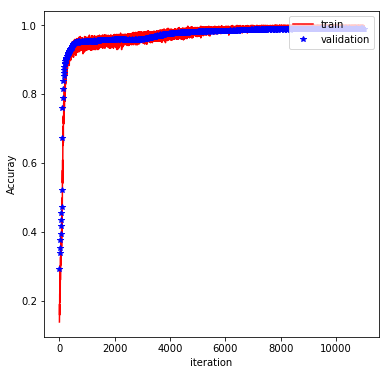

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [16]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.912800
